Première approche de la classification, et des différents scores pour déterminer la puissance des modéles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.22.1'

# Resources

**Books:**

Introduction to Statistical Learning:
http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf

Hands on Machine Learning with scikit-learn and tensorflow:
https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf


**Scikit-learn doc:**

https://scikit-learn.org/stable/tutorial/basic/tutorial.html

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


**Other resources:**

https://www.youtube.com/watch?v=UqYde-LULfs

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb

# Classification with scikit-learn : predicting heart diseases with machine learning

## The Heart disease dataset

For discovering classification, we're gonna use a rather classic dataset: the heart disease dataset. This dataset contains 13 symptoms and other attributes of patients that have been checked for a heart disease, such as their age, their cholesterol blood level, the type of pain they report, .... observed on 303 patients. These 13 attributes are called the *features*. And for each of these patients, we know if they have a heart disease or not: the field called *target* in the dataset. This field is generally called the *classes* of the problem, in this case we have two classes : 0 for healthy patients, and 1 for patients with a heart disease, hence it is called a *binary classification problem*.

As with linear regression, we generally denote the feature matrix by $X$, and the classes with $y$, where, in this dataset:

<div style="font-size: 150%;" align= "center"> 
$X \in \mathbb{R}^{303 \times 13}$, $y \in  \{0,1\}^{303}.$
</div>

The goal of classification is to learn a function, or *classifier*, $f$ that approximates the true classes $y$ from the features $X$:

<div style="font-size: 150%;" align= "center"> 
$y \approx f(X)$
</div>

However as $y$ is categorical in classification problems since it represents different classes, as opposed to a continuous value as in linear regression, we cannot use linear regression for solving these problems, and we need different models. 

Also note that classification is not always binary, and can classify features between more than 2 classes (will not be covered today, but the models that we will use here can be directly used with any number of classes).

To get a better idea of these concepts, read chapter 4.1 and 4.2 from the *Introduction to Statistical Learning* book.

First, let's load the dataset into a pandas DataFrame:

In [3]:
patients = pd.read_csv('../data/heart.csv')

Let's have a look at the column and content:

In [4]:
patients.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [5]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Here are the 13 features, and the classes assignation column called here *target*. We can see that there is no missing values in the data, so far so good. Their names correspond to the following clinical observations:

|Name |Type |	Description |
|-----|-----|---------------|
|age      |integer | age of patient |
|sex      |integer | 1=male; 0=female |
|cp       |integer | chest pain type: 0=typical angina; 1=atypical angine; 2=non-anginal pain; 3=asymptomatic |
|trestbps |integer | resting blood pressure (mm Hg) |
|chol     |integer | serum cholestrol (mg/dl) |
|fbs      |integer | fasting blood sugar: 1 if > 120 mg/dl; 0 otherwise |
|restecg  |integer | resting electrocardiographic results: 0=normal; 1=having ST-T wave abnormality; 2=showing probable or definite left ventricular hypertrophy |
|thalach  |integer | maximum heart rate achieved |
|exang    |integer | exercise induced angina: 1=yes; 0=no |
|oldpeak  |float   | ST depression induced by exercise relative to rest |
|slope    |integer | the slope of the peak exercise ST segment: 0=upsloping; 1=flat; 2=downsloping |
|ca       |integer | number of major vessels (0-4) colored by flourosopy |
|thal     |integer | 1=normal; 2=fixed defect; 3=reversable defect |
|target      |integer | predicted attribute; 0=NO HEART DISEASE; 1=HEART DISEASE |

Some of these features have continuous values such as *age* or *chol*, while others are categorical such as *cp* or *slope*. We will see that categorical variables need to be handled differently when preprocessing the data.

This dataset is derived from : https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Getting into the data

Let's now have a look of the distribution of the values of each columns:

In [6]:
patients.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.326733,0.455446
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.583020,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


We can see that the distribution of the features are different: the age vary from 29 to 77, whereas cholesterol rates from 126 to 564. To avoid some features to bias the classifier because they have larger values than others, we will need to center their means to 0 and scale their variance to 1 when preprocessing them.
Let's now plot the histogram of each feature :

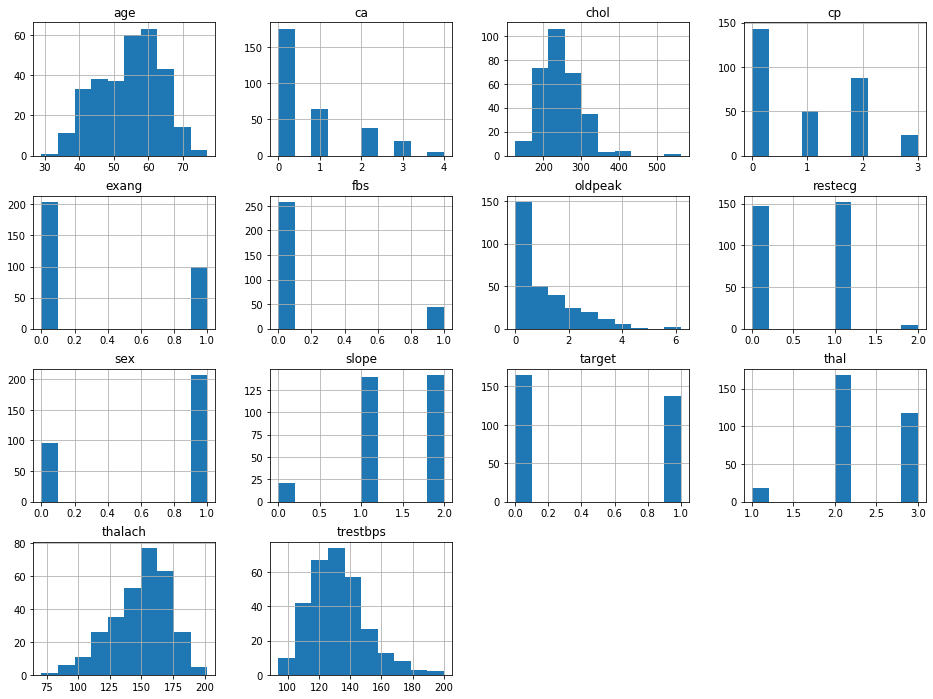

In [7]:
rcParams['figure.figsize'] = 16,12
plots = patients.hist()

It is quite clear now that some of the features are categorical with peaks only at some value, whereas others are continuous.

Another important thing to check when performing classification is the balance between the target classes: is there as many samples (=patients) that are sick as there are healthy patient:

Text(0.5, 1.0, 'Count of each Target Class')

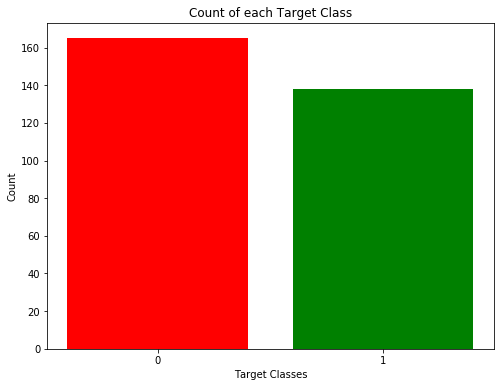

In [8]:
rcParams['figure.figsize'] = 8,6
plt.bar(patients['target'].unique(), patients['target'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

A too much imbalanced dataset can bias the classification model towards the class with more samples. Here we see that the two classes, healthy and having a heart diseased, are quite balanced in this dataset. (Some classification models allow for correcting this if needed, you can later have a look at : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html , but we won't need it today).

We can also plot the correlation matrix beween all the features and the target classes to get an idea of which features will probably be good predictors for our problem :

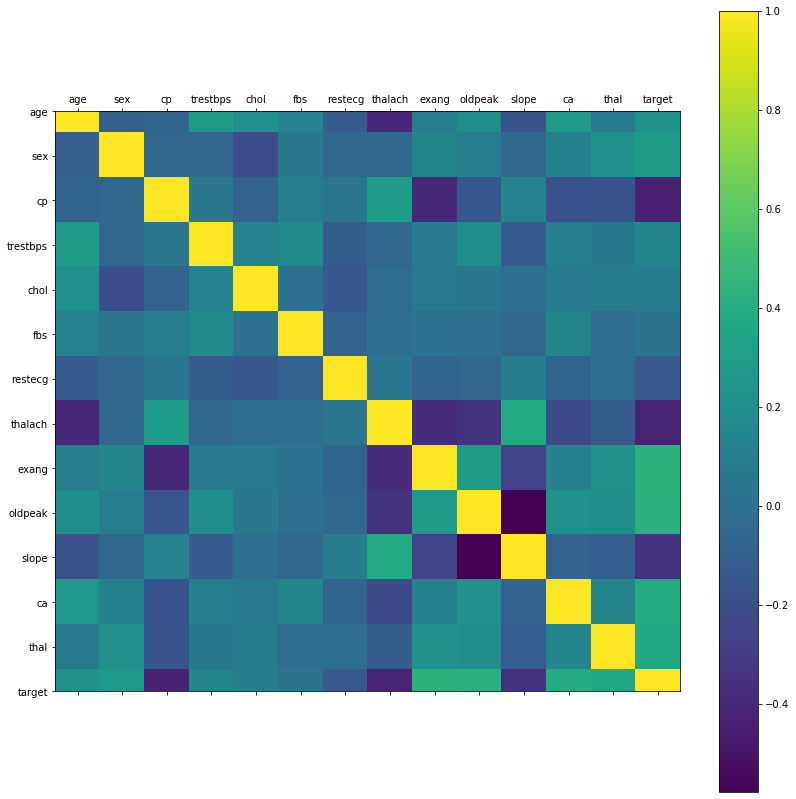

In [9]:
#Some correlate with target, others not
rcParams['figure.figsize'] = 20, 14
plt.matshow(patients.corr())
plt.yticks(np.arange(patients.shape[1]), patients.columns)
plt.xticks(np.arange(patients.shape[1]), patients.columns)
plt.colorbar();

Here we can see that no single feature has a very high or very low correlation with the target value, meaning that the diagnostic is complex and will require a combination of all of these.

## Preprocessing data

We have seen that we have categorical variables, for example the *cp* variable that describes the chest pain type reported with number from 0 to 3:
0=typical angina; 1=atypical angina; 2=non-anginal pain; 3=asymptomatic.

However these are *qualitative* categories, and there is no notion of distance between these numbers: an atypical angina is not 2 times a typical angina! 

To handle that we are going to create what we call *dummy variables*, that is, for each value 0, 1, 2, and 3, we are going to create a new feature which is a 0-1 feature only, and has a 1 value only for its own value.

In [10]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

To create dummy variables, have a look at the get_dummies function from pandas.

In [11]:
patients_dummied=pd.get_dummies(patients,columns=categorical_features)
patients_dummied

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,0,1,...,0,1,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,0,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,1,1,0,1,0,...,1,0,1,0,0,0,0,0,0,1
299,45,110,264,132,1.2,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
300,68,144,193,141,3.4,1,0,1,1,0,...,1,0,0,0,1,0,0,0,0,1
301,57,130,131,115,1.2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1


Let's now plot our new features to see the difference:

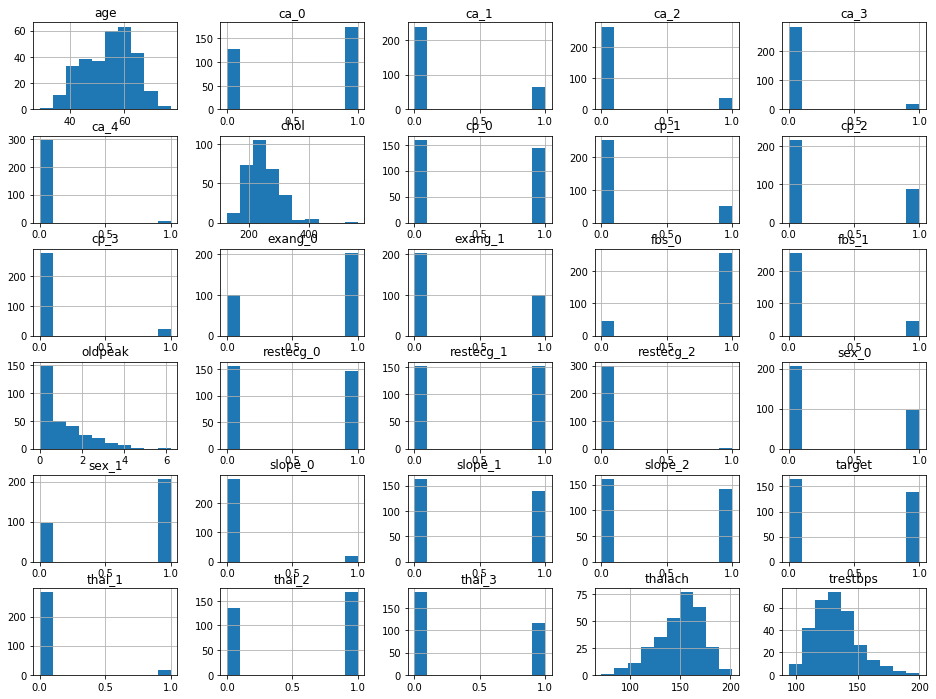

In [12]:
rcParams['figure.figsize'] = 16,12
plots = patients_dummied.hist()

We've also said that we should center and scale our continuous variables to avoid biasing the classification model, use the *StandardScaler* class from scikit-learn to do so:

In [13]:
from sklearn.preprocessing import StandardScaler

std=StandardScaler()

In [14]:
patients_dummied[continuous_features]=pd.DataFrame(std.fit_transform(patients_dummied[continuous_features]),columns=continuous_features)
patients_dummied.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,0,1,0,0,1,...,0,1,1,0,0,0,0,0,1,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,0,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0


Finally our data is ready, let's separate the features from the classes in an $X$ and $y$ variables:

In [15]:
Y=patients_dummied.pop('target')

Fill the memo.txt file to answer the following question:

1) What are the necessary preprocessing steps regarding:

a) classes:

b) categorical features:

c) continuous features:

## Classification with k-nearest neighbors, and classification metrics

One easy introduction to classification is to start with the k-neareast neighbors method (KNN). At training, it simply memorizes all the training samples features $X$ and classes $y$. At test time given the features of one sample $x'$, it identifies the $k$ training samples $x_i, i \in 1,\dots,k$ that are the closest to $x'$ (in euclidian distance), and assign the class $y'$ that is the most frequent among the k-neareast neighbor classes $y_i, i \in 1,\dots,k$.

So each test sample is assigned a probablity, for example of having a heart disease:

<div style="font-size: 150%;" align= "center"> 
$P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1) $
</div>

where the indicator function $\mathbb{1}(y_i = 1) = 1$ if $y_i = 1$, else $\mathbb{1}(y_i = 1) = 0$. So the probability of having a heart disease is the proportion of the k-nearest train samples that have a heart disease.

For an intuitive explanation of KNNs, watch the first 1:45min of this vid (the rest of it that is about Voronoi partitions is not necessary): https://www.youtube.com/watch?v=UqYde-LULfs

You can also read pages 38-40 from the *Introduction to Statistical Learning*.

You have already seen during the previous lessons that doing a single train/test split is not a very good estimation of the predictive power of the regression, and that cross-validation should always be preferred. It is the same with classification, so read about the imported classes below, and use them compute the predictions over the whole dataset by doing a 10-fold cross-validation on a k-nearest neighbors classifier, with k=15 :

In [137]:
#https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


cv=10
n_neighbors = 15

K=KNeighborsClassifier(n_neighbors=n_neighbors)

#10-fold cross validation on k-nearest neighbors
#TOFILL: 
Y_cv_pred = cross_val_predict(K, patients_dummied, Y, cv = cv)


# K.fit(patients_dummied,Y)
# Y_cv_pred =K.predict(patients_dummied)

Use these predictions to compute the accuracy of your 10-fold cross validation on your 15-nearest neighbors model :

In [17]:
from sklearn.metrics import accuracy_score

#TOFILL
score=accuracy_score(Y,Y_cv_pred)
print(score)

0.8250825082508251


$\approx$ 82.5%, pretty good for someone who doesn't know about medicine ! However accuracy is a quite limited view of the prediction abilities of your classifier. Indeed it doesn't make the difference between patients that have been incorrectly classified with a heart disease (because they were healthy) with patients that have been incorrectly classified as healthy (because they had a disease).

Let's look at the *confusion matrix* of the prediction, it gives use the number of patients that have been correctly classified as having a disease : the *true positives* (TP) ; the number of patients that have been correctly classified as not having a disease : the *true negatives* (TN); the number of patients that have been incorrectly classified as having a disease : the *false positives* (FP) ; and the number of patients that have been incorrectly classified as nothaving a disease : the *false negatives* (FN). To remember more easily, remark that the true/false refers to the *true* class of the test samples, whereas the positive/negative refers to the *predicted* class by the classifier.

The confusion matrix gives these four numbers in the following format:

|  |  |
|--|--|
|TN|FP|
|FN|TP|

The accuracy is computed by :

<div style="font-size: 150%;" align= "center"> 
    accuracy $= \frac{TP + TN}{TP + TN + FP + FN}$
</div>

One can also look at the accuracy of positive predictions, called the *precision*:

<div style="font-size: 150%;" align= "center"> 
    precision $= \frac{TP }{TP + FP}$
</div>

Or at the ratio of positive samples correctly detected by the classifier, called the *recall*:

<div style="font-size: 150%;" align= "center"> 
    recall $= \frac{TP }{TP + FN}$
</div>

These two metrics are often grouped together as a single one called the *f1-measure*:

<div style="font-size: 150%;" align= "center"> 
    F1 $=  2 \times \frac{precision \times recall}{precision + recall}$
</div>

You can read more about it in chapter 3 of the book *Hands on Machine Learning with scikit-learn and tensorflow*.

So these metrics gives use different informations about our classifier predictive performances, we are gonna see in more details how below, first compute them on the results of your cross-validation :

In [18]:
#Showing the confusion matrix of the cross-validation
from sklearn.metrics import confusion_matrix,  precision_score, recall_score, accuracy_score, f1_score
#TOFILL
C=confusion_matrix(Y,Y_cv_pred)
print('Confusion matrix:\n',C)
P=precision_score(Y,Y_cv_pred)
print('Precision score: ',P)
R=recall_score(Y,Y_cv_pred)
print('Recall score: ',R)
A=accuracy_score(Y,Y_cv_pred)
print('Accuracy score: ',A)
F=f1_score(Y,Y_cv_pred)
print('F1 score: ',F)

Confusion matrix:
 [[146  19]
 [ 34 104]]
Precision score:  0.8455284552845529
Recall score:  0.7536231884057971
Accuracy score:  0.8250825082508251
F1 score:  0.7969348659003832


Fill the memo.txt file to answer these questions:

2)a) How many patient were incorrectly diagnosed with a Heart disease ? -> 19

2)b) How many patient were incorrectly diagnosed as being Healthy ? -> 34

In general, remember that accuracy is more sensitive to class imbalance (which is not the case here as there is roughly as many positive as negative samples in the data), and that the f1 better summarizes compromize between precision and recall, and is generally preferred to accuracy when reporting a single metric on predicted classes.

## The precision/recall trade-off

We have assessed some measures that are applicables to the predicted classes, i.e. 0 or 1. Remember that KNN assigns a probability to each test sample, and simply assigns a class if this probability is higher than > 0.5:

<div style="font-size: 150%;" align= "center"> 
$y'= 1$ if and only if $P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1)  > 0.5$
</div>

Let us say we are here performing a first diagnosis test with our classifier, for further medical investigation if the prediction is positive. In this context, it is much more important to not say someone is healthy if he is not, rather than saying someone is sick if he is not (which can be discovered with later medical tests). In other words, we want to have a few false negatives, even if that implies having more false positives. This means we'd prefer to have a higher Recall, to the cost of having a lower Precision. And that implies choosing a threshold that is lower than 0.5 for assigning the classes.


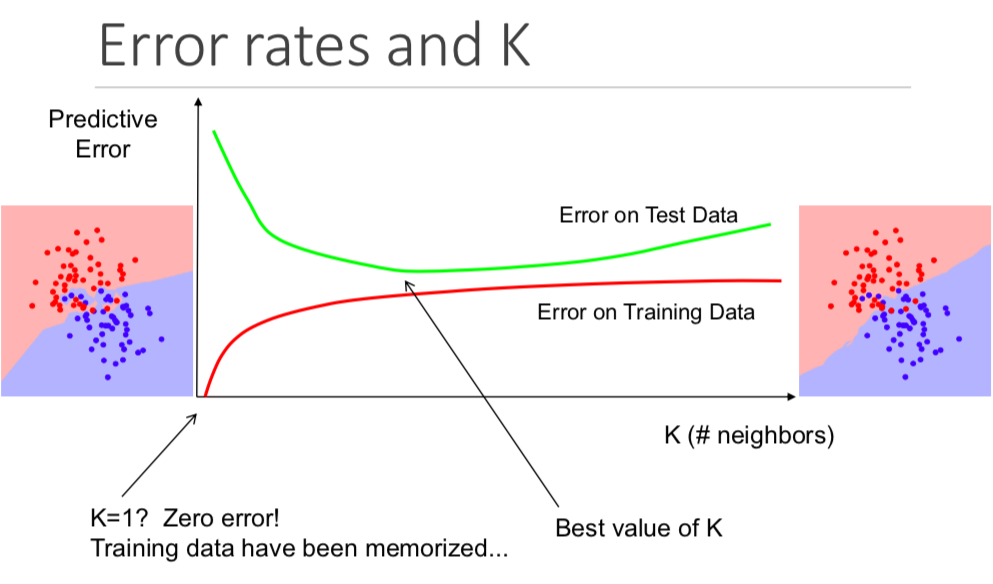

Use the *cross_val_predict* to get the probability of each sample through a 10-fold cross-validation, check the *method* argument to do so, and print these probabilities:

In [138]:
#TOFILL
cv=10
n_neighbors = 15

K=KNeighborsClassifier(n_neighbors=n_neighbors)

#10-fold cross validation on k-nearest neighbors
#TOFILL: 


# K.fit(patients_dummied,Y)
# Y_cv_pred =K.predict(patients_dummied)
# cv_scores
Y_cv_proba = cross_val_predict(K, patients_dummied, Y, cv = cv,method='predict_proba')
# First colum is P(0), the other P(1)=1-P(0)

Now let's check that if we apply a 0.5 threshold, we obtain the same predictions as before:

In [20]:
#By default KNN applies a 0.5 threshold to do its predictions:
((Y_cv_proba[:,1] > 0.5).astype(int) == Y_cv_pred).all()

True

Let's plot the different values of Precision and Recall for different thresholds:

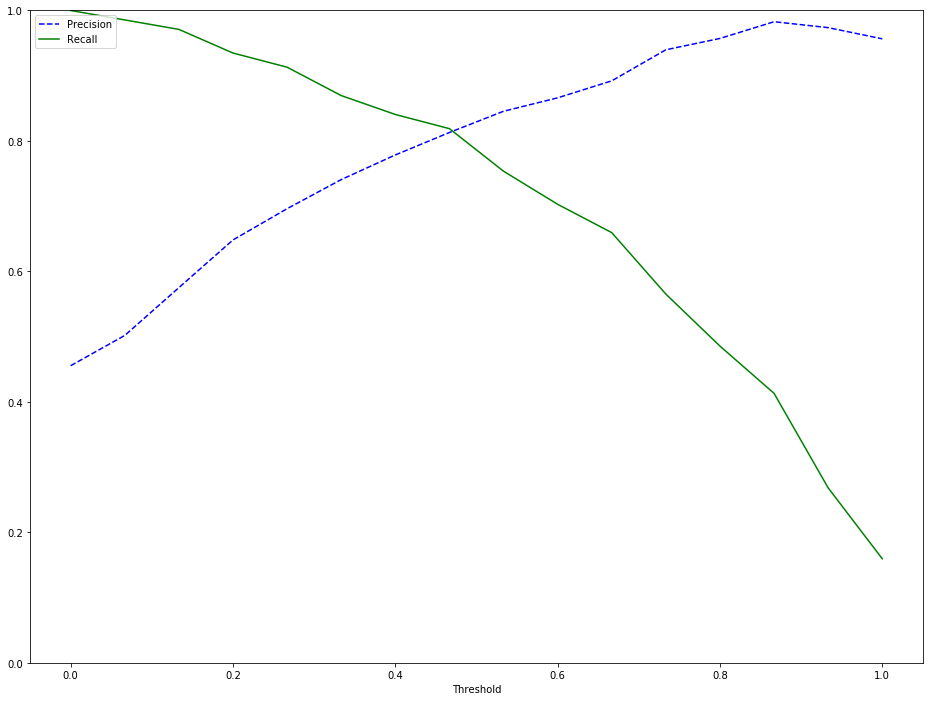

In [21]:
#Precision recall tradeoff
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])



precisions, recalls, thresholds = precision_recall_curve(Y,Y_cv_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

As we can see, the lower the probability threshold, the higher the recall and the lower the precision. There is always a cost: this is what is called the precision/recall tradeoff. A classic way of seeing that is to plot the so-called precision-recall curve, with recall as abcissa and precision in ordinate. Plot it :

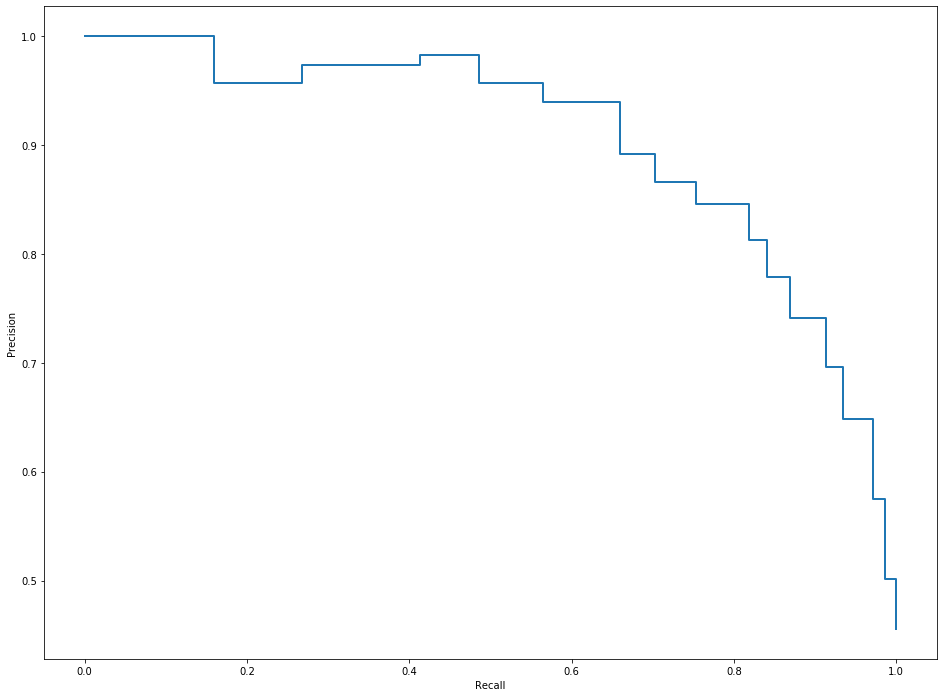

In [22]:
def plot_precision_recall_curve(precisions, recalls):
    plt.step(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plot_precision_recall_curve(precisions, recalls)


Here again, we can see the precision/recall trade-off. The better the classifier is, the closer the curve will be to the top-right corner.

So, let's not forget we are trying to diagnose people's heart disease. Let's say we are ready to accept to incorrectly label as healthy at most 1% of the patients that have a heart disease (false negatives), i.e. we want a recall of 0.99.
Given the threshold curve above, choose a threshold that approximately yields a recall of 0.99, and recompute the confusion matrix as well as precision:

In [23]:
#TOFILL
threshold = 0.01
Y_cv_pred_99recall = Y_cv_proba[:,1] > threshold
C2=confusion_matrix(Y,Y_cv_pred_99recall)
print('Confusion matrix:\n',C2)
P2=precision_score(Y,Y_cv_pred_99recall)
print('Precision score: ',P2)
R2=recall_score(Y,Y_cv_pred_99recall)
print('Recall score: ',R2)
A2=accuracy_score(Y,Y_cv_pred_99recall)
print('Accuracy score: ',A2)
F2=f1_score(Y,Y_cv_pred_99recall)
print('F1 score: ',F2)


Confusion matrix:
 [[ 30 135]
 [  2 136]]
Precision score:  0.5018450184501845
Recall score:  0.9855072463768116
Accuracy score:  0.5478547854785478
F1 score:  0.6650366748166259


Fill the memo.txt file to answer these two questions:

3)a)What is the precision if we change the threshold to have a 0.99 recall ? 

b) How many patient were incorrectly diagnosed as being Healthy (false negatives)?

## The Receiver Operating Characteristic (ROC) curve

(Yet) another way to look at your classfier performance, is to consider the false positive rate instead of precision:

<div style="font-size: 120%;" align= "center"> 
False Positive Rate (FPR) $= \frac{FP}{FP + TN}$
</div>

This is the proportion of negative test samples that are incorrectly classified as positive. Plotting the FPR against the recall gives another classic evaluation curve, the ROC curve. 

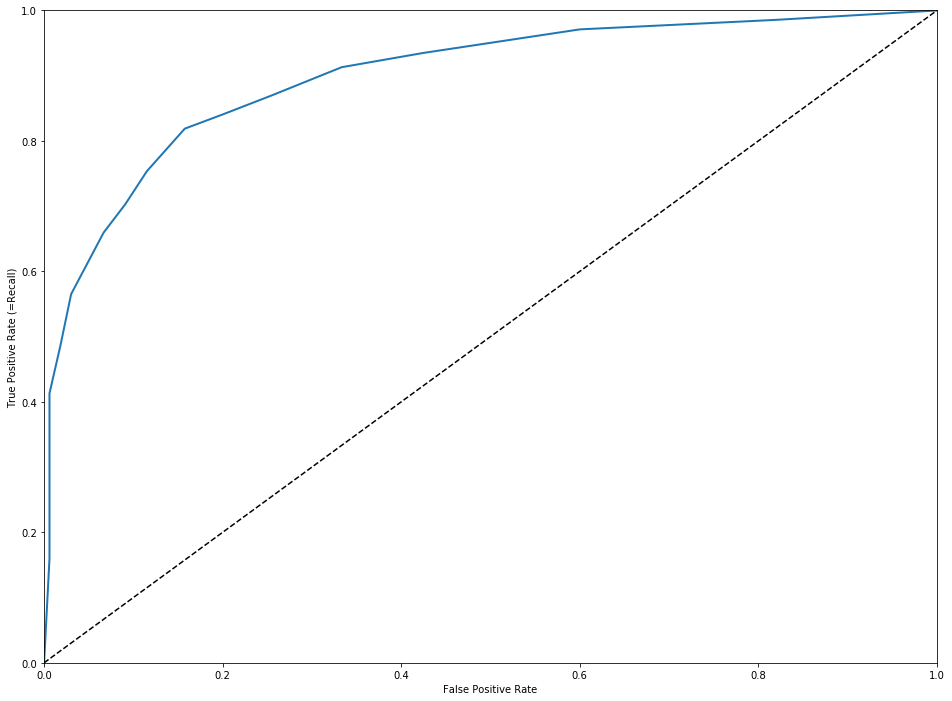

In [24]:
#The ROC curve
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (=Recall)')

#TOFILL
fpr, tpr, thresholds=roc_curve(Y,Y_cv_proba[:,1])
plot_roc_curve(fpr,tpr)

AUC means area under the curve

Here again there is a trade-off between TPR and FPR. However instead of choosing a threshold that corresponds to a single point on this curve as we did before to compute our metrics, we can compute the area under this curve (AUC). The ROC curve is always monotonically increasing and thus is a good indication that if you have a higher area under curve, you can probably find a better TPR/FPR trade-off. Computing the area under the curve is thus a metric that can compare classifiers for all possible thresholds at once. Compute it:

In [25]:
from sklearn.metrics import roc_auc_score
#TOFILL
roc_auc_score(Y,Y_cv_proba[:,1])

0.8995608256477821

Remember that this is the preferred metric overall the other metrics to evaluate your classifiers, however it requires to have access to the probability given to each test sample. Also note that when there is really few positives, we prefer to calculate the area under the precision/recall curve that we have seen before, which is also called*"average precision* (see sklearn.metrics.average_precision_score). Indeed the ROC-AUC can be biased if the dataset is too imbalanced.

If you Want to know more about all classification metrics, you can read this: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

Fill the memo.txt file to answer the following questions:

4) Choosing a metric:

a) If I can compute my test sample probabilities, which overall metric should I use ?

b) And if I have a lot more negatives than positives in the dataset ?

c) And if I only have the class predictions and no probabilities ?

## Hyper-parameters search : the best number of neighbors

Now we know what's the best way of comparing classifiers, we can start choosing the best hyper-parameter k. You have already studied the bias/variance tradeoff with linear regression. Here this is the same: with k=1 the bias will be 0, but the variance very high, and conversely with too high a k. In both cases, we will have a sub-optimal ROC-AUC.

You can read more about the bias/variance trade-off with KNNs here: https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb


Let's search for the value of k that gives the best ROC AUC score, by doing a grid-search as you already did with linear regression, but first lets play a bit with the value of k.

Plot the ROC curve and compute the ROC AUC with k=3, 15 and 50:

ROC-AUC score for k=3 is: 0.8579710144927536
ROC-AUC score for k=15 is: 0.8995608256477821
ROC-AUC score for k=50 is: 0.8973649538866929
ROC-AUC score for k=100 is: 0.8967501097935882


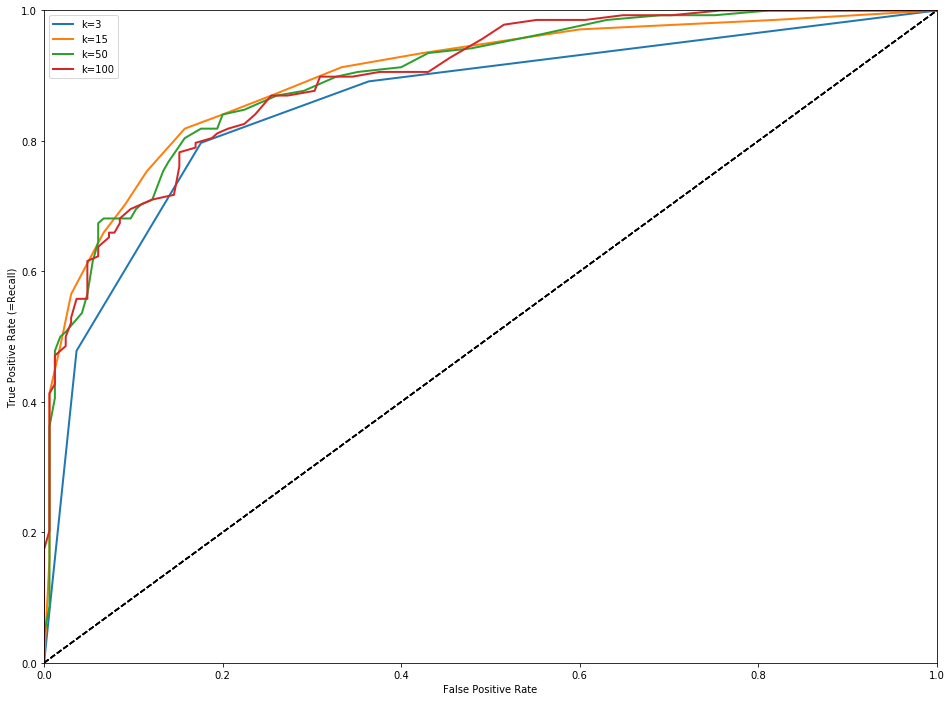

In [26]:
cv=10

def ROC_that_set(list_k):
    for k in list_k:
        n_neighbors = k
        K=KNeighborsClassifier(n_neighbors=n_neighbors)
        Y_cv_proba = cross_val_predict(K, patients_dummied, Y, cv = cv,method='predict_proba')
        fpr, tpr, thresholds=roc_curve(Y,Y_cv_proba[:,1])
        plot_roc_curve(fpr,tpr,label='k='+str(k))
        print('ROC-AUC score for k=',k,' is: ',roc_auc_score(Y,Y_cv_proba[:,1]),sep='')
    plt.legend()

list_k=[3,15,50,100]
ROC_that_set(list_k)

Now plot the ROC AUC for each k between 1 and 40:

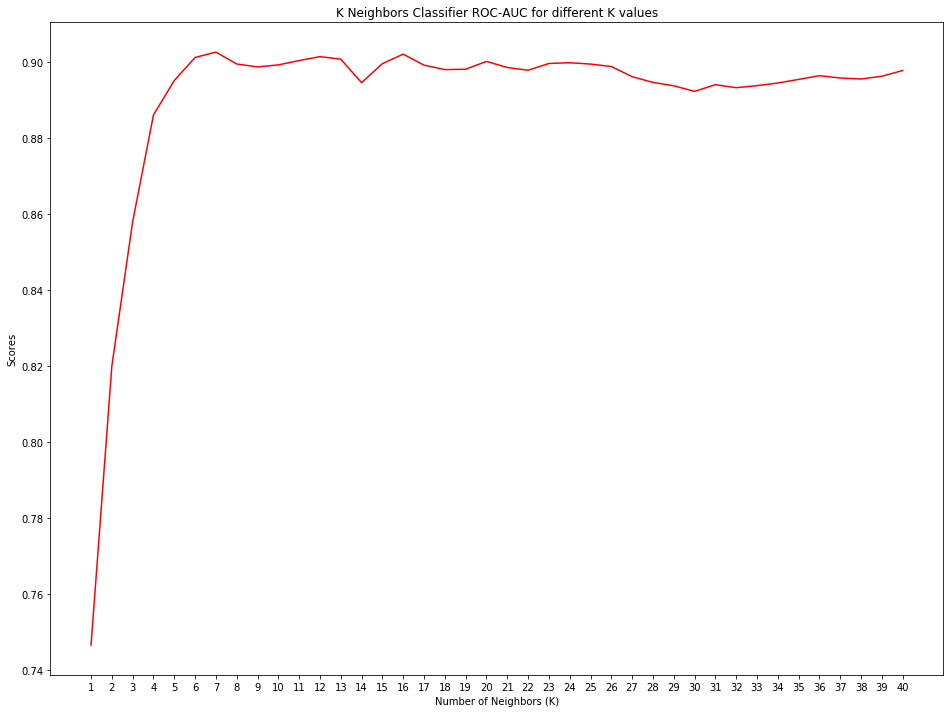

In [27]:
#Plot ROC AUC score against the number of neighbors from 1 to 40
def plot_roc_aucs(knn_roc_aucs, k_range):
    plt.plot([k for k in k_range], knn_roc_aucs, color = 'red')
    plt.xticks([i for i in k_range])
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Scores')
    plt.title('K Neighbors Classifier ROC-AUC for different K values')

def AUC_ROC_that_set(k_range):
    knn_roc_aucs=[]
    for k in k_range:
        n_neighbors = k
        K=KNeighborsClassifier(n_neighbors=n_neighbors)
        Y_cv_proba = cross_val_predict(K, patients_dummied, Y, cv = cv,method='predict_proba')
        knn_roc_aucs.append(roc_auc_score(Y,Y_cv_proba[:,1]))
    return knn_roc_aucs
    
k_range =  range(1,41)
knn_roc_aucs = AUC_ROC_that_set(k_range)
                            
plot_roc_aucs(knn_roc_aucs,k_range)

As we can see, the optimal value of k is somewhere in the middle. To automatically select the k value that yields the best ROC AUC, use the *GridSearchCV* class to perform a grid search, and print the best ROC AUC and the best k value:

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(patients_dummied, Y, test_size=0.2, random_state=41)

#Grid search k and give its roc auc score:
from sklearn.model_selection import GridSearchCV

param_grid =  {'n_neighbors': k_range}
K= KNeighborsClassifier()

#TOFILL
grid_search_K = GridSearchCV(K, param_grid, cv=10, scoring='roc_auc')
grid_search_K.fit(X_train, Y_train)

grid_results_K = pd.DataFrame(grid_search_K.cv_results_)
grid_results_K.sort_values(by=['rank_test_score'],inplace=True)
grid_results_K

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,0.003967,0.000008,0.004784,0.000013,10,{'n_neighbors': 10},0.980519,0.931818,0.925000,0.960714,0.885714,0.907143,0.888112,0.856643,0.849650,0.961538,0.914685,0.042719,1
10,0.003957,0.000014,0.004812,0.000066,11,{'n_neighbors': 11},0.987013,0.925325,0.925000,0.960714,0.896429,0.896429,0.874126,0.849650,0.842657,0.968531,0.912587,0.047068,2
12,0.003980,0.000018,0.004896,0.000094,13,{'n_neighbors': 13},0.977273,0.918831,0.921429,0.950000,0.896429,0.896429,0.863636,0.839161,0.874126,0.979021,0.911633,0.044603,3
8,0.003957,0.000012,0.004786,0.000070,9,{'n_neighbors': 9},0.974026,0.931818,0.900000,0.957143,0.903571,0.896429,0.884615,0.860140,0.849650,0.954545,0.911194,0.039832,4
7,0.003958,0.000010,0.004753,0.000075,8,{'n_neighbors': 8},0.977273,0.912338,0.857143,0.950000,0.932143,0.903571,0.902098,0.867133,0.846154,0.958042,0.910589,0.042116,5
13,0.003980,0.000016,0.004857,0.000012,14,{'n_neighbors': 14},0.980519,0.905844,0.917857,0.953571,0.892857,0.903571,0.863636,0.835664,0.867133,0.979021,0.909968,0.046435,6
17,0.003963,0.000009,0.004947,0.000090,18,{'n_neighbors': 18},0.974026,0.899351,0.907143,0.950000,0.882143,0.910714,0.895105,0.835664,0.860140,0.982517,0.909680,0.044821,7
11,0.003967,0.000014,0.004819,0.000017,12,{'n_neighbors': 12},0.980519,0.925325,0.925000,0.950000,0.882143,0.885714,0.874126,0.835664,0.867133,0.968531,0.909416,0.045245,8
23,0.003977,0.000010,0.005050,0.000021,24,{'n_neighbors': 24},0.964286,0.883117,0.896429,0.975000,0.871429,0.939286,0.877622,0.839161,0.863636,0.982517,0.909248,0.048881,9
21,0.003976,0.000008,0.005000,0.000016,22,{'n_neighbors': 22},0.970779,0.896104,0.892857,0.960714,0.878571,0.928571,0.891608,0.818182,0.874126,0.979021,0.909053,0.047850,10


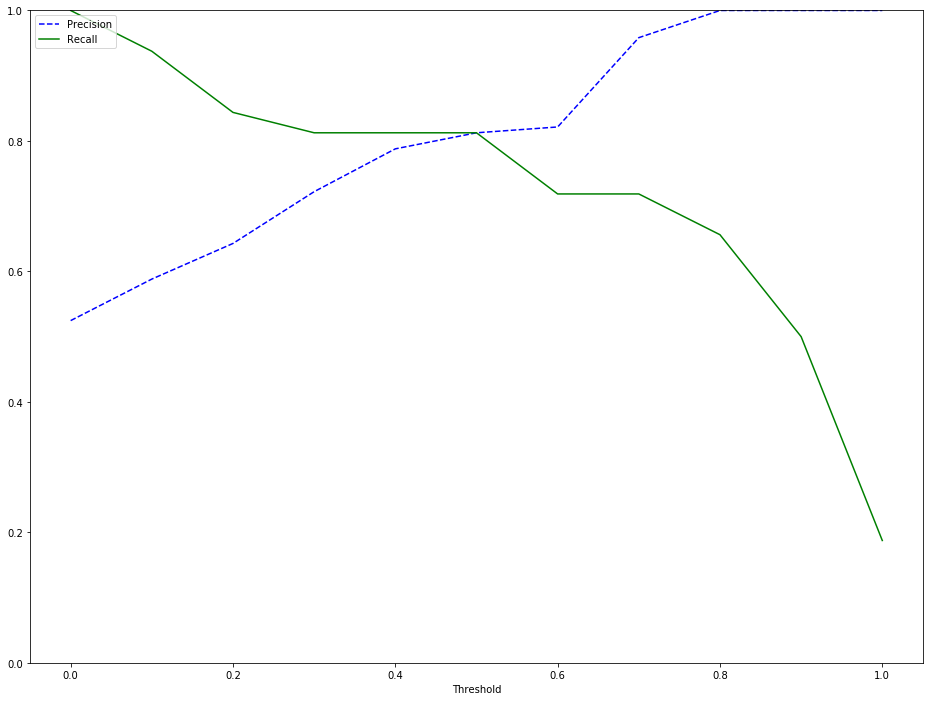

In [29]:
Y_test_cv_proba=grid_search_K.best_estimator_.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(Y_test,Y_test_cv_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Now let's retrain a model with the optimal value of k obtained and find a theshold that gives a recall of approximately 0.99. Recompute the precision now.

In [39]:
threshold = 0.1
Y_cv_pred_99recall = Y_test_cv_proba[:,1] >= threshold
C2=confusion_matrix(Y_test,Y_cv_pred_99recall)
print('Confusion matrix:\n',C2)
P2=precision_score(Y_test,Y_cv_pred_99recall)
print('Precision score: ',P2)
R2=recall_score(Y_test,Y_cv_pred_99recall)
print('Recall score: ',R2)
A2=accuracy_score(Y_test,Y_cv_pred_99recall)
print('Accuracy score: ',A2)
F2=f1_score(Y_test,Y_cv_pred_99recall)
print('F1 score: ',F2)


Confusion matrix:
 [[ 8 21]
 [ 2 30]]
Precision score:  0.5882352941176471
Recall score:  0.9375
Accuracy score:  0.6229508196721312
F1 score:  0.7228915662650602


# Optional : Try out other classification models

## Decision Trees 

Decision trees can be very useful when you need to understand how the classifier chooses the classes. You can read more about it there:

https://en.wikipedia.org/wiki/Decision_tree_learning

https://scikit-learn.org/stable/modules/tree.html

Train a decision tree with *max_depth=3*, and use the  sklearn.tree.plot_tree function to visualize it (use the *feature_names* and *class_names* parameters to have useful infos in the tree visualization).

No optimization:
Confusion matrix:
 [[24  5]
 [10 22]]
Precision score:  0.8148148148148148
Recall score:  0.6875
Accuracy score:  0.7540983606557377
F1 score:  0.7457627118644067


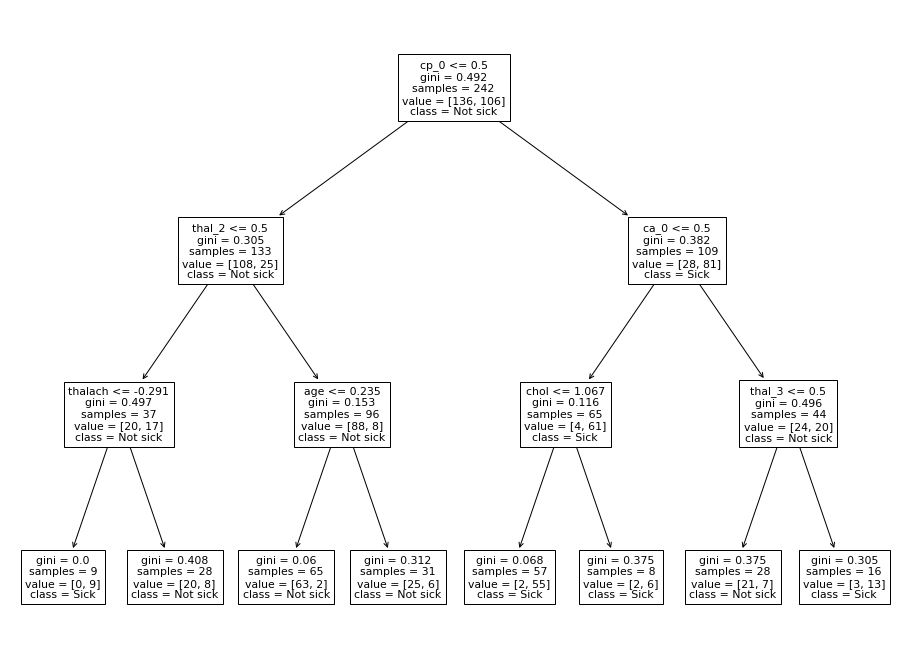

In [132]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

max_depth = 3
T=tree.DecisionTreeClassifier(max_depth=max_depth)
T.fit(X_train,Y_train)
Y_test_predict_dt=T.predict(X_test)

print('No optimization:')
C3=confusion_matrix(Y_test,Y_test_predict_dt)
print('Confusion matrix:\n',C3)
P3=precision_score(Y_test,Y_test_predict_dt)
print('Precision score: ',P3)
R3=recall_score(Y_test,Y_test_predict_dt)
print('Recall score: ',R3)
A3=accuracy_score(Y_test,Y_test_predict_dt)
print('Accuracy score: ',A3)
F3=f1_score(Y_test,Y_test_predict_dt)
print('F1 score: ',F3)

#TOFILL

tree.plot_tree(T,feature_names=X_test.columns,class_names=['Not sick','Sick']);

Grid search over the 'max_depth' parameter and compute the the best ROC-AUC for the decision tree:

In [56]:
depth_range=range(1,20)
param_grid =  {'max_depth': depth_range}
T=tree.DecisionTreeClassifier()

grid_search_T = GridSearchCV(T, param_grid, cv=10, scoring='roc_auc')
grid_search_T.fit(X_train, Y_train)

grid_results_T = pd.DataFrame(grid_search_T.cv_results_)
grid_results_T.sort_values(by=['rank_test_score'],inplace=True)
grid_results_T.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.003345,0.000086,0.002701,0.000089,3,{'max_depth': 3},0.951299,0.873377,0.892857,0.850000,0.785714,0.796429,0.944056,0.818182,0.839161,0.888112,0.863919,0.053980,1
1,0.004939,0.005115,0.002834,0.000215,2,{'max_depth': 2},0.912338,0.840909,0.875000,0.800000,0.767857,0.817857,0.863636,0.793706,0.846154,0.905594,0.842305,0.045544,2
3,0.003526,0.000104,0.002749,0.000084,4,{'max_depth': 4},0.957792,0.824675,0.753571,0.867857,0.639286,0.821429,0.947552,0.818182,0.814685,0.807692,0.825272,0.086340,3
4,0.003595,0.000096,0.002721,0.000091,5,{'max_depth': 5},0.814935,0.766234,0.767857,0.857143,0.782143,0.725000,0.818182,0.825175,0.863636,0.881119,0.810142,0.047086,4
5,0.003751,0.000089,0.002742,0.000088,6,{'max_depth': 6},0.844156,0.762987,0.853571,0.710714,0.671429,0.750000,0.884615,0.709790,0.821678,0.853147,0.786209,0.070627,5


max_depth=3 seems to be the best parameter.

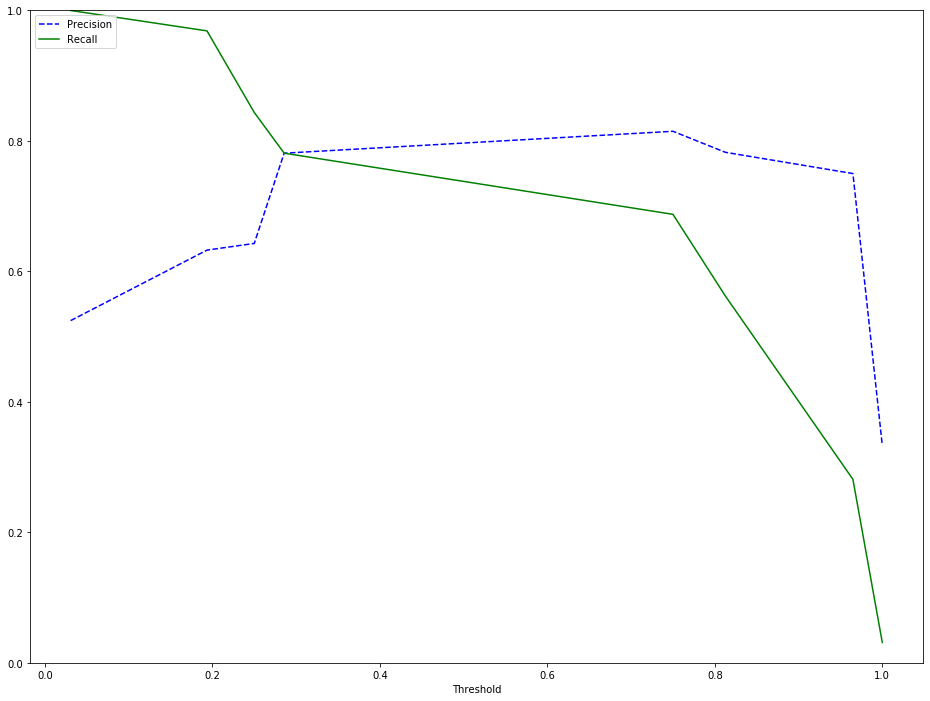

In [57]:
Y_test_cv_proba_dt=grid_search_T.best_estimator_.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(Y_test,Y_test_cv_proba_dt[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [67]:
threshold = 0.01
Y_cv_pred_99recall = Y_test_cv_proba_dt[:,1] >= threshold
C4=confusion_matrix(Y_test,Y_cv_pred_99recall)
print('Confusion matrix:\n',C4)
P4=precision_score(Y_test,Y_cv_pred_99recall)
print('Precision score: ',P4)
R4=recall_score(Y_test,Y_cv_pred_99recall)
print('Recall score: ',R4)
A4=accuracy_score(Y_test,Y_cv_pred_99recall)
print('Accuracy score: ',A4)
F4=f1_score(Y_test,Y_cv_pred_99recall)
print('F1 score: ',F4)


Confusion matrix:
 [[11 18]
 [ 1 31]]
Precision score:  0.6326530612244898
Recall score:  0.96875
Accuracy score:  0.6885245901639344
F1 score:  0.7654320987654322


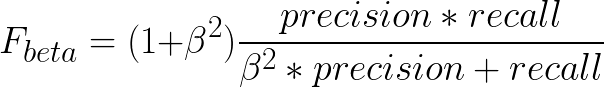

When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose. For example, with F1 score we care equally about recall and precision with F2 score, recall is twice as important to us.

## Support Vector Machines

In general Support Vector Machines (SVM) is the classification method that often gives the best predictive performances. You can read about it there:

https://scikit-learn.org/stable/modules/svm.html (beginning of section 1.4.7 gives an intuitive view of the principles of SVMs)

Similarly, grid search over the 'C' parameter and compare ROC AUC scores:

In [69]:
from sklearn.svm import SVC
#TOFILL
C_range=range(1,15)
param_grid =  {'C': C_range,'kernel' : ['linear','rbf','poly']}
S=SVC(probability=True)

#TOFILL
grid_search_S = GridSearchCV(S, param_grid, cv=10, scoring='roc_auc')
grid_search_S.fit(X_train, Y_train)

grid_results_S = pd.DataFrame(grid_search_S.cv_results_)
grid_results_S.sort_values(by=['rank_test_score'],inplace=True)
grid_results_S.head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
39,0.107217,0.042349,0.002775,0.000012,14,linear,"{'C': 14, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.921429,0.892857,0.958042,0.888112,0.944056,0.986014,0.923402,0.037423,1
33,0.080510,0.016893,0.002775,0.000011,12,linear,"{'C': 12, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.900000,0.892857,0.958042,0.888112,0.944056,0.986014,0.921259,0.038082,2
36,0.089762,0.014575,0.002818,0.000101,13,linear,"{'C': 13, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.900000,0.892857,0.958042,0.888112,0.944056,0.986014,0.921259,0.038082,2
2,0.016281,0.000302,0.002876,0.000007,1,poly,"{'C': 1, 'kernel': 'poly'}",0.980519,0.896104,0.950000,0.871429,0.921429,0.871429,0.986014,0.825175,0.916084,0.993007,0.921119,0.053420,4
30,0.085589,0.019236,0.006022,0.005063,11,linear,"{'C': 11, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.892857,0.892857,0.958042,0.888112,0.944056,0.986014,0.920544,0.038538,5
27,0.082624,0.023934,0.002793,0.000031,10,linear,"{'C': 10, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.892857,0.892857,0.958042,0.881119,0.944056,0.986014,0.919845,0.039179,6
24,0.072381,0.023436,0.002786,0.000016,9,linear,"{'C': 9, 'kernel': 'linear'}",0.967532,0.883117,0.871429,0.921429,0.892857,0.892857,0.958042,0.881119,0.944056,0.986014,0.919845,0.039179,6
18,0.061634,0.022610,0.002809,0.000044,7,linear,"{'C': 7, 'kernel': 'linear'}",0.967532,0.883117,0.878571,0.921429,0.892857,0.885714,0.958042,0.881119,0.944056,0.986014,0.919845,0.038917,6
12,0.041698,0.008202,0.002784,0.000027,5,linear,"{'C': 5, 'kernel': 'linear'}",0.967532,0.883117,0.885714,0.921429,0.892857,0.885714,0.951049,0.881119,0.944056,0.979021,0.919161,0.036387,9
21,0.075718,0.027377,0.002794,0.000022,8,linear,"{'C': 8, 'kernel': 'linear'}",0.967532,0.883117,0.864286,0.921429,0.892857,0.892857,0.958042,0.881119,0.944056,0.986014,0.919131,0.040109,10


SVMs offer the possibility to express complex combinations of the features, through different *kernels*. See:

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html

https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

Check the available kernels in scikit-learn, and do a grid-search on kernel types and other hyper-parameters of your choice.

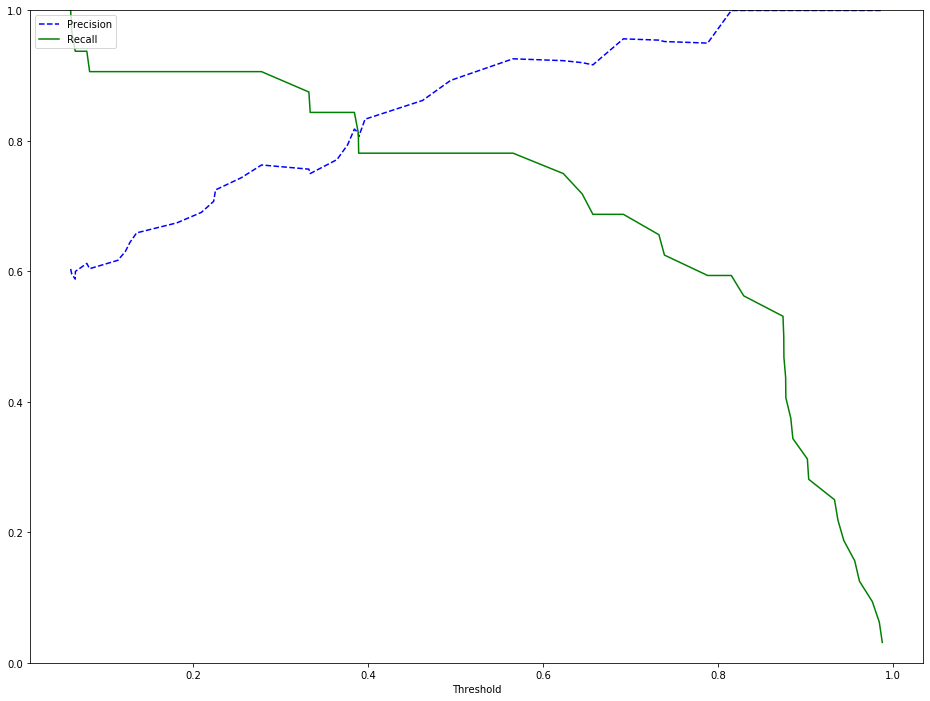

In [73]:
Y_test_cv_proba_S=grid_search_S.best_estimator_.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(Y_test,Y_test_cv_proba_S[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [74]:
threshold = 0.05
Y_cv_pred_99recall = Y_test_cv_proba_S[:,1] >= threshold
C5=confusion_matrix(Y_test,Y_cv_pred_99recall)
print('Confusion matrix:\n',C5)
P5=precision_score(Y_test,Y_cv_pred_99recall)
print('Precision score: ',P5)
R5=recall_score(Y_test,Y_cv_pred_99recall)
print('Recall score: ',R5)
A5=accuracy_score(Y_test,Y_cv_pred_99recall)
print('Accuracy score: ',A5)
F5=f1_score(Y_test,Y_cv_pred_99recall)
print('F1 score: ',F5)

Confusion matrix:
 [[ 7 22]
 [ 0 32]]
Precision score:  0.5925925925925926
Recall score:  1.0
Accuracy score:  0.639344262295082
F1 score:  0.7441860465116279


## Select the best model among all class of models and their hyper-parameters

Write a function that takes a list of different scikit-learn classifiers, as well as a list of each parameter grid to be searched over each classifier, and a scoring function ; and returns the best classifier along with its best parameters and its score. Finally, test it with KNN, SVM and DecisionTrees, and ensure you get a result that is consistent with the results previously obtained. You can also test with LogisticRegression, another powerful classification model.

In [128]:
def select_best_model_overall(classifiers_list, param_grids_dict, X, Y, cv=10, scoring='roc_auc'):
    #TOFILL
    best_parameters={}
    roc_auc_classifier={}
    for classifier in classifiers_list:
        param_grid =  param_grids_dict[classifier]
        bu=classifier()
        grid_search = GridSearchCV(bu, param_grid, cv=10, scoring=scoring)
        grid_search.fit(X, Y)
        best_parameters[classifier]=grid_search.best_params_
        roc_auc_classifier[classifier]=grid_search.best_score_
    best_classifier=max(roc_auc_classifier.items(), key=itemgetter(1))[0]
    best_score=max(roc_auc_classifier.items(), key=itemgetter(1))[1]
    return best_classifier, best_parameters, best_score

In [126]:
classifier_list=[SVC,tree.DecisionTreeClassifier,KNeighborsClassifier]
param_grids_dict={SVC:{'C': range(1,101),'kernel' : ['linear','rbf','poly'],'degree':range(1,6)},tree.DecisionTreeClassifier:{'max_depth': range(1,11)},KNeighborsClassifier:{'n_neighbors': range(1,21)}}

In [129]:
select_best_model_overall(classifier_list,param_grids_dict,X_train,Y_train)

(sklearn.svm._classes.SVC,
 {sklearn.svm._classes.SVC: {'C': 4, 'degree': 1, 'kernel': 'poly'},
  sklearn.tree._classes.DecisionTreeClassifier: {'max_depth': 3},
  sklearn.neighbors._classification.KNeighborsClassifier: {'n_neighbors': 10}},
 0.9252797202797203)